In [1]:
import geopandas as geop
from matplotlib import pyplot as plt

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

import numpy as np

import seaborn as sns

In [3]:
raw_data = geop.read_file('./PlanBlocksR5_v2neighbors.shp')

In [4]:
raw_data['Far_2017'].mean()

1.4865835489691301

In [5]:
raw_data.columns

Index(['Block_ID', 'd_tam', 'd_metro', 'd_cbd', 'in_Eco', 'in_Ind', 'in_His',
       'Far_2004', 'Far_2017', 'TAZ_ID', 'Density00', 'Density10', 'Density22',
       'Perc_Res', 'Perc_Job', 'd_zgc', 'Den_road', 'Lng', 'Lat', 'Area_m2',
       'neighbors', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')

In [6]:
from train import init_data, train, predict

In [7]:
init_data()
# train()

In [17]:
from scipy import stats
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

In [108]:
class Visualize(object):
    def __init__(self, model_name):
        predictions, labels = predict(model_name)
        predictions = np.array(predictions)
        self.preds = predictions
        labels = np.array(labels)
        self.label = labels


        self.r2 = stats.linregress(predictions, labels)[2]** 2
        
        self.error = labels - predictions
        levels = [0., .4, .6, 1., 2.4, 4., 6.]
        self.d_label = np.digitize(labels, levels)
        self.d_preds = np.digitize(predictions, levels)
        
        prediction_df = geop.GeoDataFrame({
            'error': self.error,
            'lvlerror': (self.d_label - self.d_preds),
            'predictions': self.preds,
            'lvl_preds': self.d_preds,
            'lvl_truth': self.d_label,
        })
        self.df = raw_data.join(prediction_df)
    
    def plot_map(self, col):
        ax = self.df.plot(column=col, vmin=0, vmax=5 if col[0:3] != 'lvl' else 7,
                          figsize=(15, 15), legend=True, cmap='cool')
        ax.set_title(col)

    def plot_whole_lvl_error(self):
        # Plot error level graph
        ax = self.df.plot(column='lvlerror', vmin=-6, vmax=6, figsize=(15, 15), legend=True, cmap='coolwarm')
        ax.set_title('Level difference 2017')
    
    def plot_district(self, coors, colname='error'):
        xs, ys = coors
        # Paint subplot in wangjing
        corners = [(xs[0], ys[0]), (xs[0], ys[1]), (xs[1], ys[1]), (xs[1], ys[0])]
        wangjing = geop.GeoSeries([Polygon(corners)])
        wangjing = geop.GeoDataFrame({'geometry': wangjing})

        res = geop.overlay(self.df, wangjing, how='intersection')

        ax = res.plot(column=colname, vmin=-6, vmax=6, figsize=(15, 15), legend=True, cmap='coolwarm')
        ax.set_title('Detailed level difference 2017')

    def statistics(self):
        print('R^2 = {}'.format(self.r2))
        print('Mean error = {}'.format(np.mean(np.abs(self.error))))
        print('Mean level difference = {}'.format(np.abs(np.mean((self.d_label == self.d_preds)))))

    def tam(self):
        dn = np.array(self.df[['d_tam', 'error']])
        d_tam, error = dn[:, 0], dn[:, 1]
        d_tam = np.digitize(d_tam, np.arange(0, 10, 1.))
        xls = np.arange(0, 11, 1.)
        yls = [np.mean([error[i] for i in range(len(d_tam)) if d_tam[i] == lvl]) for lvl in xls]
        plt.plot(xls, yls)

    def regression(self):
        plt.scatter(predictions, labels)
        
    def error_plot(self):
        d_error = np.array(self.df['lvlerror']).reshape(-1)
        sns.distplot(d_error)
        
wangjing = ((116.43, 116.50), (39.97, 40.02))
w_zgc = ((116.29, 116.315), (39.97, 39.99))

In [68]:
v_neisum = Visualize('neisum')

In [162]:
v_neisum.statistics()

R^2 = 0.33710819586515595
Mean error = 0.8823335984421492
Mean level difference = 0.4065503575821072


/home/laekov/.local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


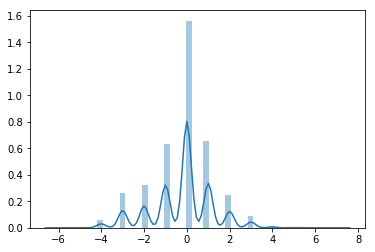

In [69]:
v_neisum.error_plot()

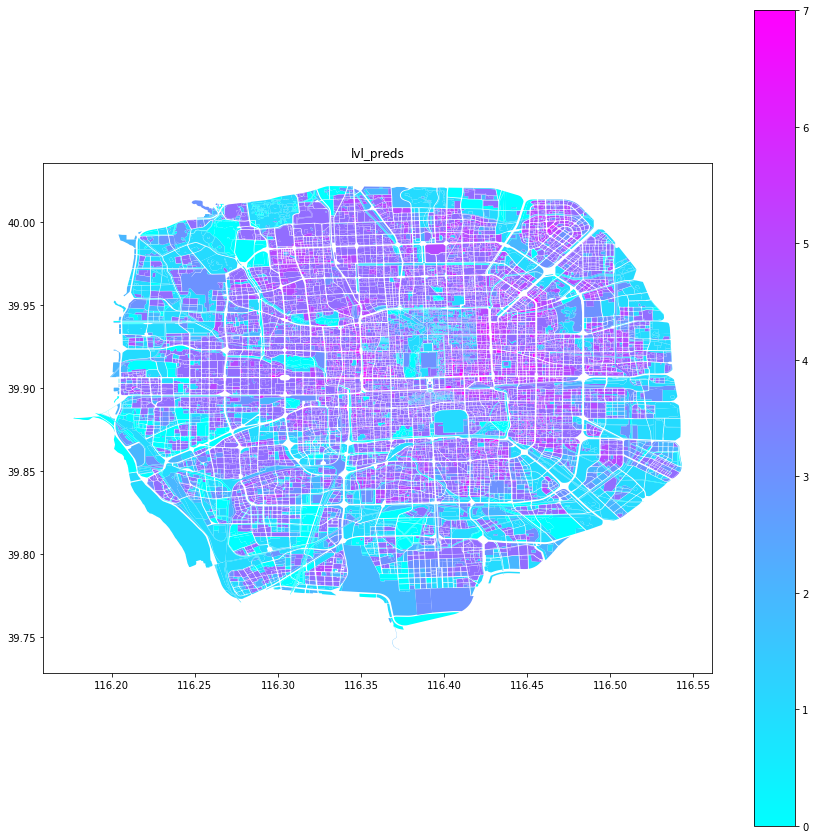

In [70]:
v_neisum.plot_map('lvl_preds')

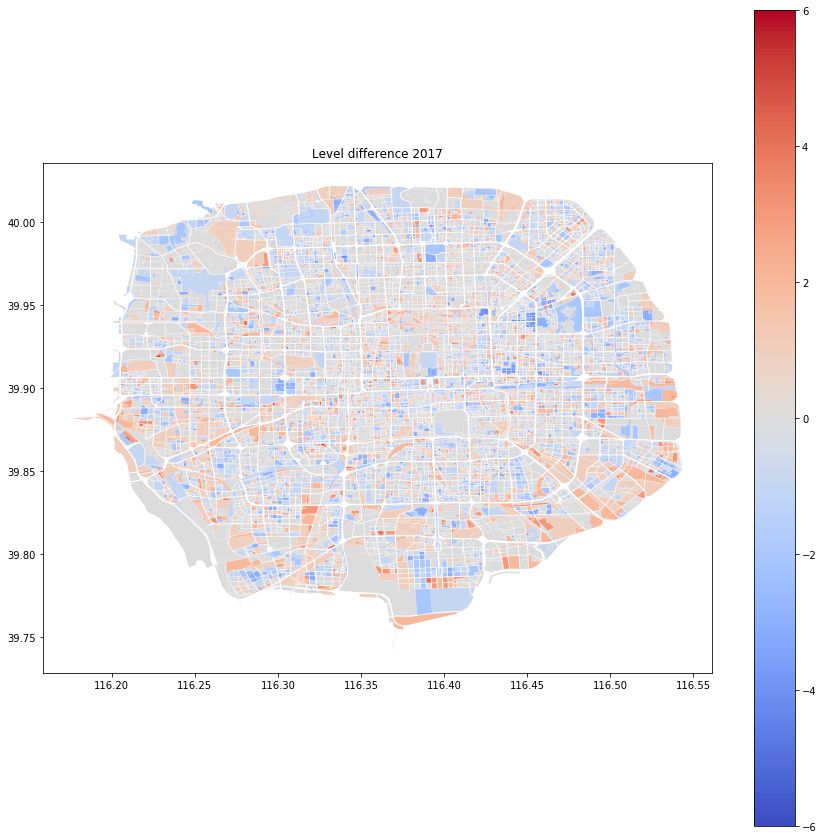

In [77]:
v_neisum.plot_whole_lvl_error()

In [123]:
v_mlp = Visualize('mlp')

/home/laekov/miniconda3/lib/python3.7/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: {'init': 'epsg:4326'} and None
  other.crs))


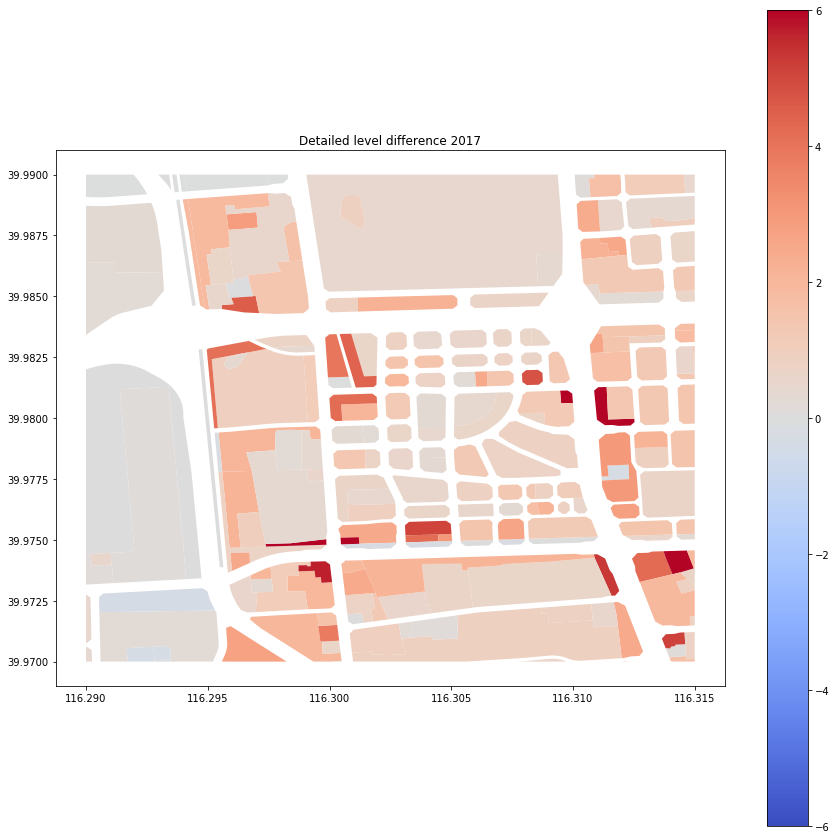

In [124]:
v_mlp.plot_district(w_zgc, 'predictions')

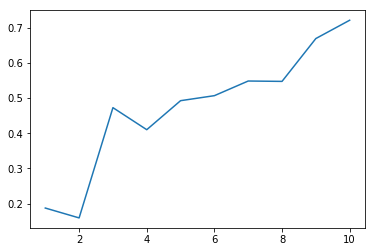

In [87]:
v_mlp.tam()

In [74]:
v_mlp.statistics()

R^2 = 0.1576158360834812
Mean error = 1.0193582431442054
Mean level difference = 0.39980868218466725


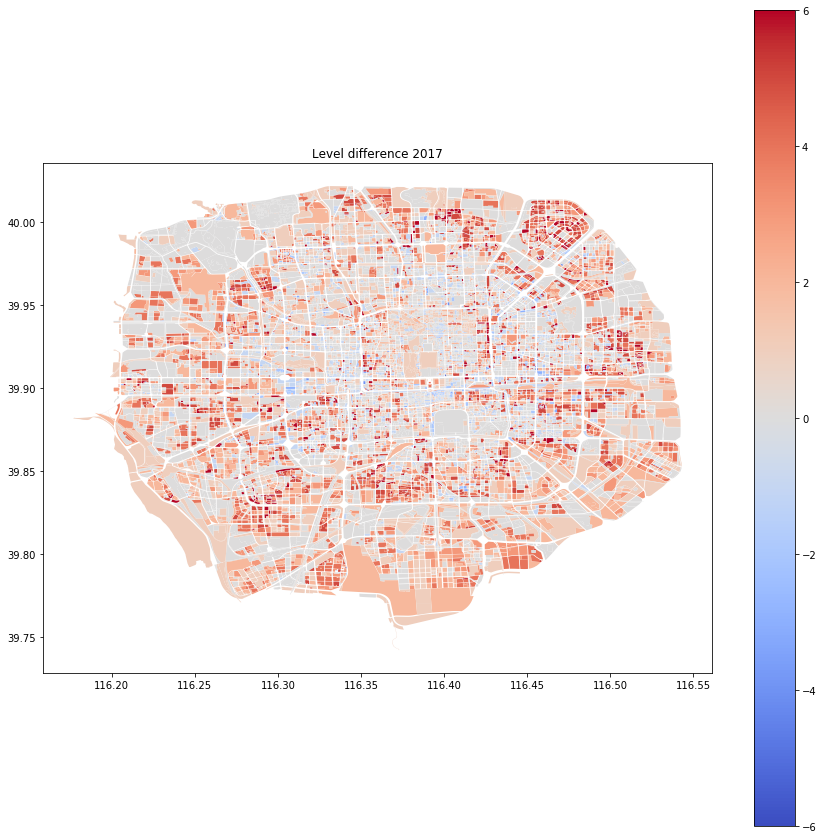

In [76]:
v_mlp.plot_whole_lvl_error()

In [166]:
v_neisumnow = Visualize('neisum')
v_neisumnow.statistics()

R^2 = 0.39337102902627435
Mean error = 0.8251951787875552
Mean level difference = 0.43798114152963147


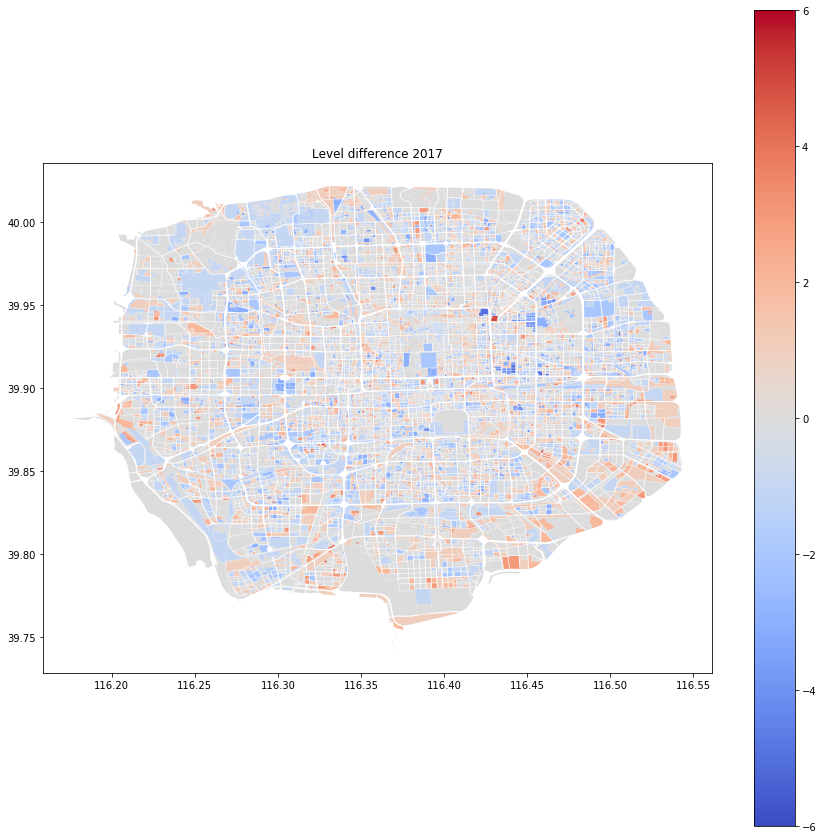

In [167]:
v_neisumnow.plot_whole_lvl_error()

/home/laekov/miniconda3/lib/python3.7/site-packages/geopandas/base.py:29: UserWarning: GeoSeries crs mismatch: {'init': 'epsg:4326'} and None
  other.crs))


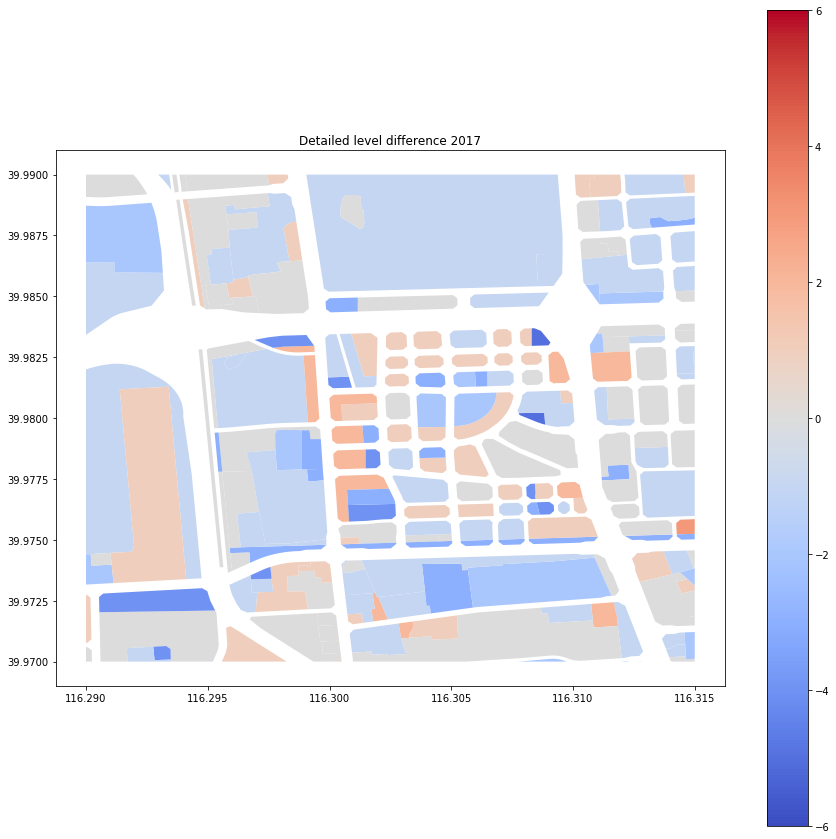

In [171]:
v_neisumnow.plot_district(w_zgc, 'lvlerror')
# v_neisumnow.plot_district(w_zgc, 'Far_2004')
# v_neisumnow.plot_district(w_zgc, 'Far_2017')

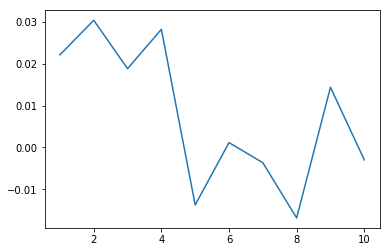

In [170]:
v_neisumnow.tam()

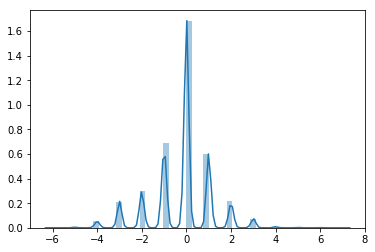

In [169]:
v_neisumnow.error_plot()